In [1]:
from fastbook import *
from fastai.tabular.all import *
import os
import nfl_data_py as nfl
import numpy as np
import pandas as pd

In [2]:
# Calculate Expected Pass Rate

In [3]:
# Set CONSTANTS
# SEASONS = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
SEASONS = [2016,2017,2018,2019,2020,2021]

In [4]:
# get play by play for season
cols = ['game_id',
        'play_id',
        'epa',
        'season_type',
        'season','week',
        'qtr',
        'drive','series',
        'down',
        'ydstogo',
        'yards_gained',
        'wp',
        'ep',
        'yardline_100',
        'home_team',
        'away_team',
        'posteam','posteam_score',
        'defteam','defteam_score',
        'posteam_timeouts_remaining',
        'defteam_timeouts_remaining',
        'half_seconds_remaining',
        'game_half',
        'fixed_drive_result',
        'play_type',
        'penalty_team',
        'penalty_type',
        'penalty_yards']

df_pbp = nfl.import_pbp_data(years=SEASONS, columns=cols, downcast=True, cache=False)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
Downcasting floats.


In [5]:
df_pbp['score_diff'] = df_pbp.posteam_score - df_pbp.defteam_score
df_pbp['home'] = np.select([df_pbp.posteam == df_pbp.home_team],[1], default=0) 

In [6]:
is_down = df_pbp['down'].isin([1,2,3,4])
is_runpass = df_pbp['play_type'].isin(['run','pass'])


df = df_pbp.loc[(is_runpass & is_down), ['play_type',
                                         'season',
                                         # 'season_type',
                                         'score_diff',
                                         'home',
                                         'down',
                                         'ydstogo',
                                         'yardline_100',
                                         'game_half',
                                         'qtr',
                                         'half_seconds_remaining',
                                         'posteam_timeouts_remaining',
                                         'defteam_timeouts_remaining',
                                         'wp']].dropna().copy()
print(df.play_type.value_counts())
df.sample(25)

pass    120263
run      83099
Name: play_type, dtype: int64


,play_type,season,score_diff,home,down,ydstogo,yardline_100,game_half,qtr,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,wp
32187,run,2016,4.0,1,1.0,10.0,33.0,Half1,2.0,536.0,3.0,2.0,0.734578
123589,run,2018,-3.0,0,2.0,5.0,48.0,Half2,3.0,1052.0,3.0,3.0,0.417166
234455,pass,2020,-7.0,0,2.0,10.0,59.0,Half1,2.0,309.0,2.0,3.0,0.300674
160770,pass,2019,-7.0,1,1.0,10.0,39.0,Half1,2.0,214.0,3.0,1.0,0.414402
126435,run,2018,0.0,1,1.0,10.0,14.0,Half2,4.0,900.0,3.0,3.0,0.692877
130588,pass,2018,-3.0,1,1.0,10.0,86.0,Half2,4.0,98.0,1.0,2.0,0.272812
142268,run,2018,0.0,0,2.0,10.0,75.0,Half1,1.0,1760.0,3.0,3.0,0.415296
12859,run,2016,-7.0,0,1.0,10.0,28.0,Half1,2.0,548.0,3.0,2.0,0.367073
18723,pass,2016,-17.0,1,2.0,25.0,48.0,Half2,4.0,297.0,3.0,3.0,0.005248
113726,pass,2018,-11.0,0,1.0,10.0,25.0,Half2,4.0,283.0,2.0,3.0,0.092404


In [7]:
df.dtypes

play_type                      object
season                          int64
score_diff                    float32
home                            int64
down                          float32
ydstogo                       float32
yardline_100                  float32
game_half                      object
qtr                           float32
half_seconds_remaining        float32
posteam_timeouts_remaining    float32
defteam_timeouts_remaining    float32
wp                            float32
dtype: object

In [8]:
procs = [Categorify, FillMissing, Normalize]
cat_names = ['season',
             # 'season_type',
             'home','down','qtr','game_half']
cont_names = ['score_diff','wp','ydstogo','yardline_100','half_seconds_remaining','posteam_timeouts_remaining','defteam_timeouts_remaining']

In [9]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
# splits = TrainTestSplitter(test_size=0.2, random_state=None, stratify='play_type',
#                     train_size=None, shuffle=True)

In [10]:
to = TabularPandas(df, procs=procs,
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='play_type',
                   splits=splits)

In [11]:
dls = to.dataloaders(bs=64)

In [12]:
dls.show_batch()

,season,home,down,qtr,game_half,score_diff,wp,ydstogo,yardline_100,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,play_type
0,2020,1,2.0,4.0,Half2,5.000000e+00,0.748905,18.0,82.999999,783.999998,3.0,3.000000e+00,pass
1,2016,1,2.0,1.0,Half1,3.279754e-08,0.528030,10.0,75.000000,1714.999998,3.0,3.000000e+00,pass
2,2020,1,3.0,4.0,Half2,1.100000e+01,0.996868,5.0,8.000001,119.000026,3.0,3.000000e+00,run
3,2017,0,1.0,3.0,Half2,-6.000000e+00,0.350041,10.0,25.999999,964.000000,2.0,2.000000e+00,run
4,2020,1,2.0,3.0,Half2,1.100000e+01,0.894456,10.0,58.000000,1707.000015,3.0,3.000000e+00,pass
5,2018,0,3.0,2.0,Half1,3.279754e-08,0.509229,2.0,30.000000,779.999999,3.0,3.000000e+00,pass
6,2017,0,1.0,4.0,Half2,-1.400000e+01,0.011966,10.0,65.000000,159.000005,3.0,-1.883819e-08,pass
7,2019,1,2.0,4.0,Half2,8.000000e+00,0.942733,11.0,31.999999,434.999995,3.0,2.000000e+00,pass
8,2020,1,1.0,4.0,Half2,-3.100000e+01,0.000106,10.0,64.000000,400.999987,3.0,2.000000e+00,run
9,2018,0,1.0,2.0,Half1,-1.400000e+01,0.177393,10.0,25.000001,77.000003,2.0,3.000000e+00,pass


In [13]:
learn = tabular_learner(dls, metrics=accuracy)

In [14]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.575309,0.569351,0.688754,00:24


In [31]:
preds, y, loss = learn.get_preds(with_loss=True)
acc = accuracy(preds,y)
print('The accuracy is {0}%.'.format(acc))

The accuracy is 0.6911464333534241%.


In [32]:
learn.show_results()

,season,home,down,qtr,game_half,score_diff,wp,ydstogo,yardline_100,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,play_type,play_type_pred
0,0.0,1.0,3.0,3.0,2.0,-0.509427,-0.673138,0.100907,-1.458527,1.274652,0.567673,0.577185,0.0,0.0
1,0.0,2.0,2.0,3.0,2.0,0.435679,0.700520,-1.160178,0.922312,0.697668,0.567673,0.577185,0.0,1.0
2,0.0,1.0,2.0,4.0,2.0,-2.116107,-1.678366,-0.907961,0.470773,-0.747557,0.567673,-0.894672,0.0,0.0
3,0.0,2.0,2.0,1.0,1.0,0.813721,0.772548,-0.655744,1.168605,0.286590,0.567673,0.577185,0.0,0.0
4,0.0,2.0,3.0,2.0,1.0,0.813721,0.982659,0.353124,0.470773,-0.153983,0.567673,-0.894672,1.0,0.0
5,0.0,2.0,1.0,2.0,1.0,0.152147,0.444403,0.353124,-0.965940,-1.470170,-2.121647,-0.894672,0.0,0.0
6,0.0,1.0,3.0,3.0,2.0,0.435679,0.527404,2.118642,-0.760695,0.677391,-0.776987,0.577185,1.0,0.0
7,0.0,1.0,3.0,3.0,2.0,0.152147,-0.132444,-1.916829,0.388675,1.624898,0.567673,0.577185,0.0,1.0
8,0.0,2.0,3.0,3.0,2.0,-1.265512,-1.401449,-1.160178,-0.514402,0.459870,0.567673,0.577185,0.0,0.0


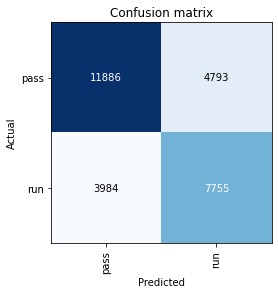

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [34]:
from sklearn.metrics import roc_curve, auc
probs = (preds[:,1])
# compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs)

# Compute ROC area
roc_auc = auc(fpr,tpr)
print(f'ROC area is {roc_auc}')

ROC area is 0.7582984502533804


In [35]:
print(preds)
print(probs)

tensor([[0.3737, 0.6263],
        [0.4781, 0.5219],
        [0.7247, 0.2753],
        ...,
        [0.4000, 0.6000],
        [0.5927, 0.4073],
        [0.4688, 0.5312]])
tensor([0.6263, 0.5219, 0.2753,  ..., 0.6000, 0.4073, 0.5312])


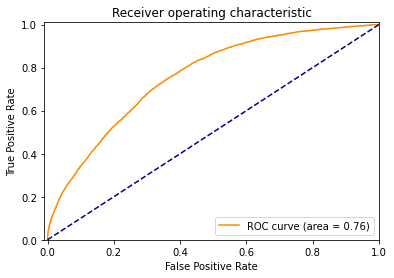

In [36]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")


In [37]:
test_df = df.copy()
test_df.drop(['play_type'], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)
preds = learn.get_preds(dl=dl)

In [38]:
df['xp'] = preds[0][:,0]

In [39]:

df['play_type_class'] = np.select([df['play_type'] == 'pass', df['play_type'] == 'run'],[1,0], default=0)

df['bin_pred_prob'] = round(df['xp'] / 0.05) * 0.05

df['situation'] = np.select([((df.down == 1) & (df.ydstogo == 10)),
                             (df.down == 2),
                             (df.down == 3)],
                            ['1st & 10', '2nd down', '3rd down'], default = 'Other')
df_xp=(df.groupby(['situation', 'bin_pred_prob']).agg({'play_type_class':[('n_plays','count'),('n_complete', 'sum')]})
 .droplevel(level=0, axis=1)
 .reset_index()
 .assign(bin_actual_prob= lambda x: x.n_complete / x.n_plays)
)
df_xp

,situation,bin_pred_prob,n_plays,n_complete,bin_actual_prob
0,1st & 10,0.00,19,0,0.000000
1,1st & 10,0.05,972,25,0.025720
2,1st & 10,0.10,697,43,0.061693
3,1st & 10,0.15,553,63,0.113924
4,1st & 10,0.20,547,84,0.153565
...,...,...,...,...,...
79,Other,0.80,566,445,0.786219
80,Other,0.85,592,500,0.844595
81,Other,0.90,895,810,0.905028
82,Other,0.95,633,590,0.932070


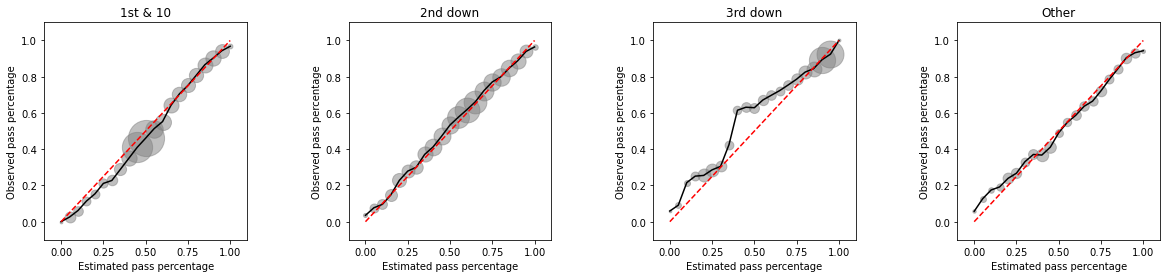

In [40]:
# from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = (0,1)
        low_y, high_y = (0,1)
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes


fig, ax = subplots(1,4, figsize=(20,4))
fig.subplots_adjust(wspace=0.5)
for idx, situation in enumerate(df_xp.situation.unique()):
    for row_idx, row in df_xp[df_xp.situation == situation].iterrows():
        ax[idx].scatter(x=row.bin_pred_prob, y=row.bin_actual_prob, s=2**np.log(row.n_plays), alpha=0.5,color='grey')
    ax[idx].plot('bin_pred_prob', 'bin_actual_prob', data=df_xp[df_xp.situation == situation], color='k')
    add_identity(ax[idx], color='r', ls='--')
    ax[idx].set_title(situation)
    ax[idx].set_xlim([-0.1,1.1])
    ax[idx].set_ylim([-0.1,1.1])
    ax[idx].set_xlabel('Estimated pass percentage')
    ax[idx].set_ylabel('Observed pass percentage')
    

plt.show()

In [25]:
# Calculate error between expected and observed

wm = lambda x: np.average(x, weights=df_xp.loc[x.index, "n_plays"])

df_xp['cal_diff'] = abs(df_xp.bin_pred_prob - df_xp.bin_actual_prob)
xp_cv_cal_error = df_xp.groupby('situation').agg(n_complete=('n_complete','sum'),weighted_cal_error=('cal_diff',wm))
round(np.average(xp_cv_cal_error.weighted_cal_error, weights=xp_cv_cal_error.n_complete),4)


0.0209

In [26]:
# https://www.opensourcefootball.com/posts/2020-09-28-nflfastr-ep-wp-and-cp-models/#expected-pass-model-calibration-results
# model calibration of NFLverse  Expected Pass Model is 0.008

In [27]:
# explore why 3rd down is a problem for the model
xp_range = (df.xp > .25)&(df.xp < .75)
on_3rd_down = (df.down == 3)

df[xp_range & on_3rd_down]

,play_type,season,score_diff,home,down,ydstogo,yardline_100,game_half,qtr,half_seconds_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,wp,xp,play_type_class,bin_pred_prob,situation
6,run,2016,0.0,1,3.0,1.0,66.0,Half1,1.0,1674.0,3.0,3.0,0.561710,0.415108,0,0.40,3rd down
46,run,2016,3.0,1,3.0,1.0,76.0,Half1,2.0,739.0,3.0,3.0,0.634312,0.409336,0,0.40,3rd down
51,pass,2016,3.0,1,3.0,1.0,66.0,Half1,2.0,622.0,2.0,3.0,0.647152,0.444656,1,0.45,3rd down
65,run,2016,-10.0,0,3.0,1.0,1.0,Half1,2.0,237.0,2.0,2.0,0.278399,0.415164,0,0.40,3rd down
76,pass,2016,3.0,1,3.0,1.0,53.0,Half1,2.0,57.0,2.0,1.0,0.690105,0.548884,1,0.55,3rd down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291495,pass,2021,4.0,1,3.0,22.0,96.0,Half2,3.0,983.0,3.0,3.0,0.662826,0.702032,1,0.70,3rd down
291515,pass,2021,4.0,1,3.0,2.0,64.0,Half2,4.0,481.0,3.0,3.0,0.799685,0.504568,1,0.50,3rd down
291522,run,2021,-4.0,0,3.0,1.0,70.0,Half2,4.0,344.0,3.0,3.0,0.270337,0.482696,0,0.50,3rd down
291526,pass,2021,-4.0,0,3.0,2.0,55.0,Half2,4.0,246.0,3.0,3.0,0.255382,0.620491,1,0.60,3rd down


In [28]:
# test LeaveOneGroupOut (season) validation 
from sklearn.model_selection import LeaveOneGroupOut, train_test_split

train, test  = train_test_split(df, test_size=0.2)

val_pct, tst_preds = L(), L()
logo = LeaveOneGroupOut()
logo.get_n_splits(groups=train.season)

for train_idx, valid_idx in logo.split(train.index,  train['play_type'], groups=train.season): # right here
    splits = (L(list(train_idx)), L(list(valid_idx)))
    procs = [Categorify, Normalize, FillMissing]
    to = TabularPandas(train, procs, cat_names, cont_names, y_names='play_type',
                       splits=splits)
    dls = to.dataloaders(bs=512)
    learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
    learn.fit(3, 1e-2)
    test_dl = learn.dls.test_dl(test)
    with learn.no_bar():
        val_pct.append(learn.validate()[-1])
        tst_preds.append(learn.get_preds(dl=test_dl))

    

epoch,train_loss,valid_loss,accuracy,time
0,0.574155,0.573158,0.684489,00:03
1,0.568948,0.561361,0.696534,00:03
2,0.563512,0.560740,0.695647,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.571902,0.563721,0.694369,00:03
1,0.566801,0.569872,0.668548,00:03
2,0.565293,0.557615,0.697620,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.574339,0.581831,0.684592,00:03
1,0.563092,0.575572,0.688029,00:03
2,0.564537,0.567015,0.685461,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.577842,0.575469,0.683935,00:03
1,0.567997,0.564236,0.700568,00:03
2,0.564952,0.565331,0.695074,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.572029,0.578385,0.686388,00:03
1,0.564377,0.578575,0.686205,00:03
2,0.564437,0.572383,0.684514,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.572007,0.578784,0.688683,00:03
1,0.567225,0.570003,0.691639,00:03
2,0.561863,0.569707,0.691146,00:03


In [29]:
for i, (pred, truth) in enumerate(tst_preds):
    print(f'Fold {i+1}: {accuracy(pred, truth)}')

Fold 1: 0.6972930431365967
Fold 2: 0.69675213098526
Fold 3: 0.6955228447914124
Fold 4: 0.6936788558959961
Fold 5: 0.6946868896484375
Fold 6: 0.6952769756317139


In [30]:
sum_preds = []
for i, (pred, truth) in enumerate(tst_preds):
    sum_preds.append(pred.numpy())
avg_preds = np.sum(sum_preds, axis=0) / 16
print(f'Average Accuracy: {accuracy(tensor(avg_preds), tst_preds[0][1])}')

Average Accuracy: 0.6999483704566956
